In [1]:
#general definitions and imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import logging
logging.Logger.disabled=True

import os
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import numpy as np
import matplotlib.pyplot as plt
from sympy import *

import ipytest
ipytest.autoconfig()
from pytest import approx

from pathlib import Path

from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import SubCircuit
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Probe.Plot import plot
from PySpice.Math import *

import schemdraw
import schemdraw.elements as elm
from schemdraw import dsp
from schemdraw import logic

from IPython.display import display, HTML

## setup spice library path
directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)
## set the project directory as directory_path
directory_path = Path(os.path.abspath('')).resolve()

In [2]:
# definitions
        
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    __R = 100@u_kΩ

    def __init__(self, R=100@u_kΩ, w=0.4, name='voltage_divider'):
        self.__R__ = R
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )
        
    def wiper(self, w) :
        if w == 0 :
            self.R1.resistance = self.__R * 0.0000001
            self.R2.resistance = self.__R * 0.9999999
        elif w == 1 :
            self.R1.resistance = self.__R * 0.9999999
            self.R2.resistance = self.__R * 0.0000001
        else :
            self.R1.resistance = self.__R * w
            self.R2.resistance = self.__R * (1.0-w)
            
class JackIn(SubCircuitFactory):
    __name__ = 'jack_in'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=1@u_kΩ, name='jack_in', value='DC 5'):
        self.__name__ = name
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.V(1, 'n2', self.gnd, value)

class JackOut(SubCircuitFactory):
    __name__ = 'jack_out'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=0@u_kΩ, name='jack_out'):
        self.__name__ = name
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.R(1, 'n2', 'n3', R)


# construction

The function depends on the patching and settings of the potentiometers. When the potentiometer is at the centre position, the output signal is muted. No output signal is present. When turning to the right, the output will get louder until the output signal is equal to the input. When turning the potentiometer to the left, the output signal will be phase-shifted by 180°.

The first input is wired to a default DC voltage of +5V. With this input is not connected this voltage will be added as an offset to the mixed signal. With the potentiometer, the offset can be adjusted from -5V to +5V.

The output jacks are switched. When something is plugged into an output, this output is removed from the summed output. This channel is a simple attenuverter.

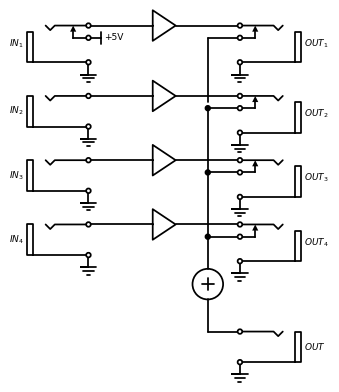

In [32]:
d = schemdraw.Drawing(unit=2.1, inches_per_unit=0.5, lw=1.75, fontsize=9)

JI4 = d.add(elm.AudioJack(xy=[0, d.unit], lftlabel='$IN_4$'))
d.add(elm.Ground("right", xy=JI4.sleeve))
d.add(elm.Line( "right", l=d.unit, at=JI4.tip))
D4 = d.add(dsp.Amp())
d.add(elm.Line( "right", l=d.unit))
JO4 = d.add(elm.AudioJack("left", switch=True, flip=True, anchor='tip', rgtlabel='$OUT_4$'))
d.add(elm.Ground("right", xy=JO4.sleeve))

JI3 = d.add(elm.AudioJack(xy=[0, 2*d.unit], lftlabel='$IN_3$'))
d.add(elm.Ground("right", xy=JI3.sleeve))
d.add(elm.Line( "right", l=d.unit, at=JI3.tip))
D3 = d.add(dsp.Amp())
d.add(elm.Line( "right", l=d.unit))
JO3 = d.add(elm.AudioJack("left", switch=True, flip=True, anchor='tip', rgtlabel='$OUT_3$'))
d.add(elm.Ground("right", xy=JO3.sleeve))

JI2 = d.add(elm.AudioJack(xy=[0, 3*d.unit], lftlabel='$IN_2$'))
d.add(elm.Ground("right", xy=JI2.sleeve))
d.add(elm.Line( "right", l=d.unit, at=JI2.tip))
D2 = d.add(dsp.Amp())
d.add(elm.Line( "right", l=d.unit))
JO2 = d.add(elm.AudioJack("left", switch=True, flip=True, anchor='tip', rgtlabel='$OUT_2$'))
d.add(elm.Ground("right", xy=JO2.sleeve))

JI1 = d.add(elm.AudioJack(xy=[0, 4*d.unit], switch=True, lftlabel='$IN_1$'))
d.add(elm.Vdd("down", xy=JI1.tipswitch, botlabel="+5V"))
d.add(elm.Ground("right", xy=JI1.sleeve))
d.add(elm.Line( "right", l=d.unit, at=JI1.tip))
D1 = d.add(dsp.Amp())
d.add(elm.Line( "right", l=d.unit))
JO1 = d.add(elm.AudioJack("left", switch=True, flip=True, anchor='tip', rgtlabel='$OUT_1$'))
d.add(elm.Ground("right", xy=JO1.sleeve))

d.add(elm.Line("left", l=d.unit/2, xy=JO1.tipswitch))
d.add(elm.Line("down"))

d.add(elm.Line("left", l=d.unit/2, xy=JO2.tipswitch))
d.add(elm.Dot())
d.add(elm.Line("down"))

d.add(elm.Line("left", l=d.unit/2, xy=JO3.tipswitch))
d.add(elm.Dot())
d.add(elm.Line("down"))

d.add(elm.Line("left", l=d.unit/2, xy=JO4.tipswitch))
d.add(elm.Dot())
d.add(elm.Line("down", l=d.unit/2))
S = d.add(dsp.Sum())  

d.add(elm.Line( "down", xy=S.E, l=d.unit/2))
d.add(elm.Line( "right", l=d.unit/2))
JO = d.add(elm.AudioJack("left", anchor="tip", flip=True, rgtlabel='$OUT$'))
d.add(elm.Ground("right", xy=JO.sleeve))

d.draw()


One interesting thing about the circuit is the attenuverter section. It uses an OPAMP in a differential configuration. The resistors $R_3$ and $R_4$ are replaced with a potentiometer to make them adjustable.

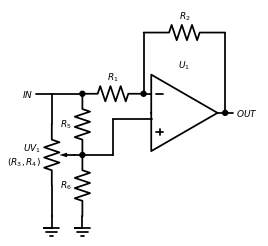

In [34]:
#d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)
d = schemdraw.Drawing(unit=2.0, inches_per_unit=0.5, lw=1.75, fontsize=9)

O = d.add(elm.Opamp( label='$U_1$'))

d.add(elm.Line( "left", xy=O.in1, l=d.unit/8))
R1 = d.add(elm.Resistor( "left", label='$R_1$'))
d.add(logic.Dot())    
R2 = d.add(elm.Resistor( "down", label='$R_5$'))
d.add(elm.Resistor( "down", label='$R_6$'))
d.add(elm.Ground)

L1 = d.add(elm.Line('left', l=d.unit/2, xy=R1.end))
d.add(elm.Line('down', l=d.unit/2))
RV = d.add(elm.Potentiometer('down', toplabel='$UV_1$\n($R_3,R_4$)'))
d.add(elm.Line('down', l=d.unit/2))
d.add(elm.Ground)

d.add(elm.Line('left', l=d.unit/4, xy=L1.end, lftlabel='$IN$'))

d.add(elm.Line('right', tox=R2.end, xy=RV.tap))
d.add(logic.Dot())

d.add(elm.Line('right', l=d.unit/2, xy=R2.end))
d.add(elm.Line('up', l=d.unit*0.58))
d.add(elm.Line('right', l=d.unit*0.63))

d.add(logic.Dot(xy=R1.start))
d.add(elm.Line('up', l=d.unit))
d.add(elm.Resistor('right', label='$R_2$', tox=O.out+d.unit/8))
d.add(elm.Line('down', toy=O.out))
d.add(logic.Dot())

d.add(elm.Line('right', l=d.unit/4, xy=O.out, rgtlabel='$OUT$'))

d.draw()

$$
\begin{array}{c}
Vout = \Bigl(1 + \frac{R2}{R1}\Bigr) \Bigl(\frac{R4}{R3+R4}\Bigr) * V2 - \Bigl(\frac{R2}{R1}\Bigr) * V1
\end{array}
$$

Above is the formula of the OPAMP differential amplifier. There are also the Resistors $R_5$ and $R_6$. These resistors make the response of the potentiometer logarithmic [[2]](https://sound-au.com/pots.htm). To calculate that these Resistors are in parallel to the Resistors $R_3$ and $R_4$.

$$
\begin{array}{c}
Vout = \Bigl(1 + \frac{R2}{R1}\Bigr) \Bigl(\frac{\Bigl(\frac{R4*R6}{R3+R5}\Bigr)}{\Bigl(\frac{R3*R5}{R3+R5}\Bigr)+\Bigl(\frac{R4*R6}{R3+R5}\Bigr)}\Bigr) * V2 - \Bigl(\frac{R2}{R1}\Bigr) * V1
\end{array}
$$

100


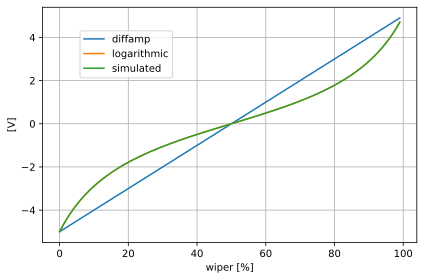

In [38]:
R1, R2, R3, R4, V1, V2 = symbols("R1 R2 R3 R4 V1 V2")
expr = (1 + R2 / R1 ) * ( R4 / (R3+R4) ) * V2 - (R2/R1) * V1

res1 = []
for resistance in np.arange(0, 100000, 1000) :
    res1.append(expr.evalf(subs={R1: 100000, R2: 100000, R3: 100000-resistance, R4: resistance, V1: 5, V2: 5}))

from sympy import *
R1, R2, R3, R4, R5, R6, V1, V2 = symbols("R1 R2 R3 R4 R5 R6 V1 V2")
expr = ( 1 + R2 / R1 ) * ( (R4*R5/(R4+R5)) / ((R3*R6/(R3+R6))+(R4*R6/(R4+R6))) ) * V2 - (R2/R1) * V1
res2 = []
for resistance in np.arange(0, 100000, 1000) :
    res2.append(expr.evalf(subs={R1: 100000, R2: 100000, R3: 100000-resistance, R4: resistance, R5: 47000, R6: 47000, V1: 5, V2: 5}))
    

# calcultate the pot sweep
circuit = Circuit('attenuverter')
circuit.include(spice_library['OPA2134'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'INPUT', circuit.gnd, 'DC 5 AC 5 SIN(0 5V 1k)')

rv1 = circuit.R('RV1', 'INPUT', 'RV1out', 100@u_kΩ)
rv2 = circuit.R('RV2', 'RV1out', circuit.gnd, 100@u_kΩ)
circuit.R(3, 'INPUT', 'RV1out', 47@u_kΩ)
circuit.R(4, 'RV1out', circuit.gnd, 47@u_kΩ)

circuit.R(1, 'INPUT', 'op_neg', 100@u_kΩ)
circuit.R(2, 'op_neg', 'OUT', 100@u_kΩ)

circuit.X('op', 'OPA2134', 'RV1out', 'op_neg', '+15V', '-15V', 'OUT')

attenuverter_results = []
for s in np.arange( 1, 0, -0.01 ):
    rv1.resistance = s * 100@u_kOhm
    rv2.resistance = 100@u_kOhm - (s * 100@u_kOhm)
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.operating_point()
    attenuverter_results.append(float(analysis['OUT']))

figure, ax = plt.subplots()
ax.plot(res1)  # diffamp
ax.plot(res2)  # log diffanp
ax.plot(attenuverter_results)  # simulated
ax.legend(('diffamp', 'logarithmic', 'simulated'), loc=(.1, .7))
ax.grid()
ax.set_xlabel('wiper [%]')
ax.set_ylabel('[V]')

plt.tight_layout()
plt.show()

The calculation shows the Result with a 5V input and a potentiometer sweep from 0-100%. The last curve shows the logarithmic result simulated with spice. It overlaps the calculated line.

It may be that the summing amplifier is not stable and self oscillates. In this case, small capacitors can be added to stabilize the signal.

# calibration

There is no calibration needed. But the potentiomenter knobs have to be aliged to center position.


# usage

The first input jack is wired to 5 volts when nothing is connected.

All channels are mixed to the out jack. when something is connected to the channel out, this channel is removed from the overall mix.

_mixer_
* connect the different channels from audio or cv sources to the in jacks.
* connect the out jack to something
* turn the pots clockwise to adjust the volume.

_attenuverter_
* connect all or a single channel. 
* when the pot knob is turned counterclockwise, the signal is inverted.


